# Fill missing data on a socio-demo user table:

### Two methods : 

The first way will use linear regression to predict years of birth, and logistic regression to predict genders.

The seconde way will use decision trees with Random Forest to predict missing values.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

## First method: Linear regression and Logistic regression 

In [3]:
def map_features(data):
    unq = data.unique()
    index = np.arange(len(unq))
    digit = pd.Series(index, index=unq)
    data = data.map(digit)
    return data

In [4]:
def delete_nan_rows(df, labels):
    data = df.values
    train = []
    n = len(df)
    for row in data:
        if pd.isna(row[3]) == False:
                train.append(list(row))
    train = pd.DataFrame(train, columns=labels)
    return train

In [5]:
def data_augmentation(df, labels, e):
    new_df = []
    for row in df.values:
        a = []
        for j in row:
            a.append(j**e)
        new_df.append(a)
    new_df = pd.DataFrame(new_df, columns=labels)
    df = df.append(new_df, ignore_index=True)
    return df

In [6]:
def split_data(df_train):
    X = df_train.drop(['gender'], axis=1)
    Y = df_train['gender']
        # Split training/testing data to 80/20
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.80, random_state=42)
    Y_train = Y_train.values.reshape(-1, 1)
    Y_test = Y_test.values.reshape(-1, 1)

    return X_train, Y_train, X_test, Y_test

In [7]:
def gender_features_scaling(x_train, features, x_test=None):
    for feature in features:
        if isinstance(x_test, pd.DataFrame) == False:
            _mean = x_train[feature].mean()
            _std = x_train[feature].std()
        else:
            _mean = pd.concat([x_train[feature], x_test[feature]], ignore_index=True).mean()
            _std = pd.concat([x_train[feature], x_test[feature]], ignore_index=True).std()
        x_train[feature] = (x_train[feature] - _mean) / _std
        if isinstance(x_test, pd.DataFrame):
            x_test[feature] = (x_test[feature] - _mean) / _std
    return x_train, x_test

In [8]:
def gender_theta_scaling(x_train, x_test, theta, features):
    i = 1
    for feature in features:
        _mean = pd.concat([x_train[feature], x_test[feature]], ignore_index=True).mean()
        _std = pd.concat([x_train[feature], x_test[feature]], ignore_index=True).std()
        theta[i] = (theta[i] - _mean) / _std
        i += 1
    return theta

In [10]:
def Accuracy(theta, x, y):
    correct = 0
    length = len(x)
    prediction = (sigmoid(np.dot(x, theta)))
    correct = []
    for i in range(length):
        if prediction[i] >= 0.5 and y[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
    accuracy = (np.sum(correct) / float(length))*100
    return accuracy

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
def gradient_descent(m, n, x, y, theta, learning_rate):
    tmp = np.zeros(n)
    for i in range(m):
        tmp += (sigmoid(np.dot(x[i], theta)) - int(y[i])) * x[i]
    theta -= (learning_rate / m) * tmp
    return theta

In [13]:
def cost(x, y, theta):
    m = len(x)
    _sum = 0
    for i in range(m):
        _sum += (y[i] * np.log(sigmoid(np.dot(x[i], theta)))) + ((1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], theta))))
    return float(-(1 / float(m)) * _sum)

In [14]:
def training(x, y, x_test, y_test, theta, learning_rate, nb_epoch):
    m = len(y)
    n = len(theta)
    hist_train_cost = []
    hist_test_cost = []
    hist_epoch = []
    for _iter in range(nb_epoch):
        theta = gradient_descent(m, n, x, y, theta, learning_rate)
        hist_train_cost.append(cost(x, y, theta))
        hist_test_cost.append(cost(x_test, y_test, theta))
        hist_epoch.append(_iter)
        print("Cost after epoch {0}: {1}".format(_iter, hist_train_cost[_iter]))
    plt.plot(hist_epoch, hist_train_cost)
    plt.plot(hist_epoch, hist_test_cost)
    plt.show()
    return theta

In [15]:
def yob_features_scaling(train, features):
    x = train.copy()
    for feature in features:
        _max = x[feature].max()
        _min = x[feature].min()
        _max = x[feature].max()
        _min = x[feature].min()
        x[feature] = x[feature] / (_max - _min)
    return x

In [16]:
def cleaning_yob(df, labels):
    train = []
    data = df.values
    for row in data:
        if row[0] != -1:
            train.append(list(row))
    train = pd.DataFrame(train, columns=labels)
    return (train)

In [17]:
def normal_equation(x, y, theta):
    tmp = np.linalg.inv((np.transpose(x).dot(x))).dot(np.transpose(x)).dot(y)
    for i in range(len(tmp)):
        theta[i] = tmp[i]
    return theta

In [18]:
def yob_theta_scaling(theta, x, features):
    i = 1
    for feature in features:
        _max = x[feature].max()
        _min = x[feature].min()
        theta[i] = theta[i] / (_max - _min)
        i += 1
    return theta

#### Get data.

In [19]:
data = pd.read_csv('./user_exo_2M.csv')
data.describe()

,yob,zipcode
count,2.000000e+06,1.982806e+06
mean,1.185200e+03,5.568963e+04
std,9.685971e+02,2.758348e+04
min,-1.000000e+00,0.000000e+00
25%,-1.000000e+00,3.329000e+04
50%,1.961000e+03,5.980000e+04
75%,1.982000e+03,7.750000e+04
max,1.999000e+03,9.800000e+04


## Linear regression to train a model to predict Years of birth :

In [18]:
df_yob = data.drop(['gender'], axis=1)
print(df_yob.head())

    yob        domain        firstname  zipcode
0  1985   @wanadoo.fr  b08253b305fb5ec  94450.0
1  1961       @sfr.fr  7ff135854376850  78580.0
2  1977      @free.fr  172522ec1028ab7  62640.0
3    -1  @hotmail.com  d3ca5dde60f88db  94100.0
4    -1    @gmail.com  bdaae16837dd576  78100.0


#### Selecting features.

In [19]:
features = []
for feature in df_yob.drop(['yob'], axis=1):
    features.append(feature)
labels = []
for label in df_yob:
    labels.append(label)
print(features)
print(labels)

['domain', 'firstname', 'zipcode']
['yob', 'domain', 'firstname', 'zipcode']


#### Keep the two first number of zipcode.

In [20]:
_zip = []
print(df_yob.zipcode.head(3))
for i in df_yob.zipcode:
    if np.isnan(i) == False and len(str(int(i))) > 2:
        _zip.append(int(str(i)[:2]))
    else:
        _zip.append(np.nan)
df_yob.zipcode = _zip
print(df_yob.zipcode.head(3))

0    94450.0
1    78580.0
2    62640.0
Name: zipcode, dtype: float64
0    94.0
1    78.0
2    62.0
Name: zipcode, dtype: float64


#### Quick view on 'domain' data.

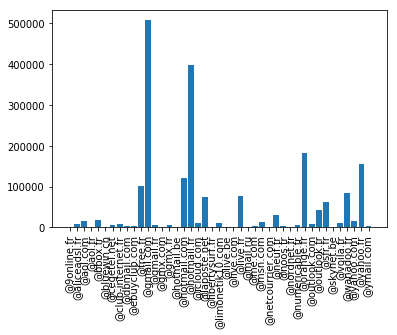

In [21]:
mpl.rcParams['agg.path.chunksize'] = 1000
a, b = np.unique(df_yob.domain, return_counts=True)
plt.bar(a, b)
plt.xticks(a, rotation='vertical')
plt.show()

In [22]:
main_domain = ['@gmail', '@hotmail.fr', '@orange.fr', '@yahoo.fr']
print(main_domain)
gmail = []
hotmail = []
orange = []
yahoo = []
for row in df_yob.values:
    if row[1] == '@gmail.com' and row[0] != -1:
        gmail.append(row[0])
    elif row[1] == '@hotmail.fr' and row[0] != -1:
        hotmail.append(row[0])
    elif row[1] == '@orange.fr' and row[0] != -1:
        orange.append(row[0])
    elif row[1] == '@yahoo.fr' and row[0] != -1:
        yahoo.append(row[0])

['@gmail', '@hotmail.fr', '@orange.fr', '@yahoo.fr']


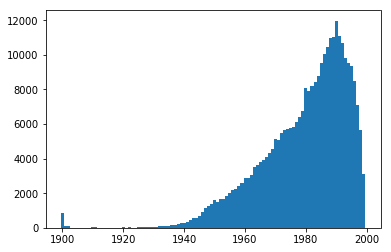

In [23]:
a, b = np.unique(gmail, return_counts=True)
plt.bar(a, b, width=1)
plt.show()

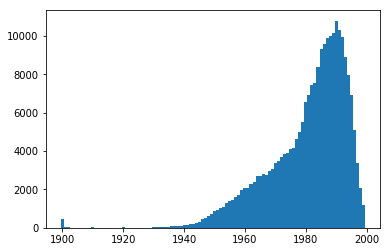

In [24]:
a, index, b = np.unique(hotmail, return_inverse=True, return_counts=True)
plt.bar(a, b, width=1)
plt.show()

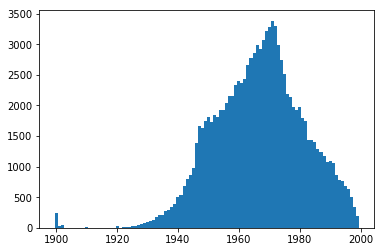

In [25]:
a, b = np.unique(orange, return_counts=True)
plt.bar(a, b, width=1)
plt.show()

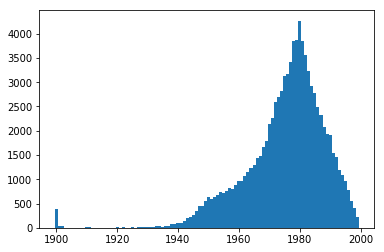

In [26]:
a, b = np.unique(yahoo, return_counts=True)
plt.bar(a, b, width=1)
plt.show()

#### Simplify features by mapping.

In [27]:
for feature in features:
    df_yob[feature] = map_features(df_yob[feature])
print(df_yob.head())

    yob  domain  firstname  zipcode
0  1985       0          0        0
1  1961       1          1        1
2  1977       2          2        2
3    -1       3          3        0
4    -1       4          4        1


#### Get mean for zipcode's missing values.

In [28]:
zip_mean = df_yob['zipcode'].mean()
df_yob.zipcode = df_yob['zipcode'].fillna(zip_mean)

#### Get rid of '-1' in yob.

In [29]:
train = cleaning_yob(df_yob, labels)

#### Get DataFrame to fil with predictions.

In [30]:
yob_to_fil = df_yob.copy()

#### Fit bias to train set and DataFrame.

In [31]:
Bias = np.ones(train.values.shape[0])
train.insert(loc=0, column='Bias', value=Bias)
Bias = np.ones(yob_to_fil.values.shape[0])
yob_to_fil.insert(loc=0, column='Bias', value=Bias)
cols = ['yob', 'Bias', 'domain', 'firstname', 'zipcode']
yob_to_fil = yob_to_fil[cols]
print(train.head())
print(yob_to_fil.head())

   Bias   yob  domain  firstname  zipcode
0   1.0  1985       0          0        0
1   1.0  1961       1          1        1
2   1.0  1977       2          2        2
3   1.0  1975       0          5        3
4   1.0  1974       4          6        4
    yob  Bias  domain  firstname  zipcode
0  1985   1.0       0          0        0
1  1961   1.0       1          1        1
2  1977   1.0       2          2        2
3    -1   1.0       3          3        0
4    -1   1.0       4          4        1


#### Features scaling.

In [32]:
x = yob_features_scaling(train, features)
#yob_to_fil = yob_features_scaling(yob_to_fil, features)

#### Get features and outputs to train.

In [33]:
y = train['yob'].values
x = x.drop(['yob'], axis=1).values

#### Creating theta / weight.

In [34]:
theta_yob = np.zeros((len(features) + 1, 1))
print(theta_yob)

[[0.]
 [0.]
 [0.]
 [0.]]


#### Training theta / weight.

In [35]:
theta_yob = normal_equation(x, y, theta_yob)
print(theta_yob)

[[ 1.97372915e+03]
 [ 6.56432881e+00]
 [ 1.56092001e+01]
 [-4.48792785e-01]]


#### Theta scaling.

In [36]:
theta_yob = yob_theta_scaling(theta_yob, df_yob, features)
print(theta_yob)

[[ 1.97372915e+03]
 [ 1.56293543e-01]
 [ 9.95421218e-04]
 [-5.09991801e-03]]


#### See what theta predict in the training set.

In [37]:
lst = []
#for x in yob_to_fil.values:
for x in train.drop(['yob'], axis=1).values:
    nb = 0
    for i in range(len(theta_yob)):
        nb += theta_yob[i] * x[i]
    lst.append(int(nb))
lst = np.array(lst)
u, indices = np.unique(lst, return_counts=True)
a = float(len(train.values))

Ocu = []
Yob = []
b = 0
for i in indices:
    Yob.append(u[b])
    Ocu.append("{}%".format(round(((i / a) * 100), 4)))
    b += 1
yob_ocu = pd.DataFrame(Ocu, Yob)
print(yob_ocu)

             0
1973   7.1907%
1974  36.6139%
1975  26.1126%
1976   9.8033%
1977   6.0465%
1978   4.3217%
1979   2.7918%
1980   1.9672%
1981   1.1725%
1982   0.8777%
1983   0.6783%
1984   0.5849%
1985    0.496%
1986   0.3975%
1987   0.3406%
1988   0.2749%
1989   0.1753%
1990     0.07%
1991   0.0339%
1992   0.0264%
1993   0.0181%
1994   0.0057%
1995   0.0005%


#### Predict missing values in yob.

In [38]:
yob = []
tmp = [] 
for row in yob_to_fil.values:
    nb = 0
    if row[0] == -1:
        for i in range(len(theta_yob)):
            nb += theta_yob[i] * row[i + 1]
        yob.append(int(nb))
        tmp.append(int(nb))
    else:
        yob.append(row[0])

#### See what theta predict in the data set.

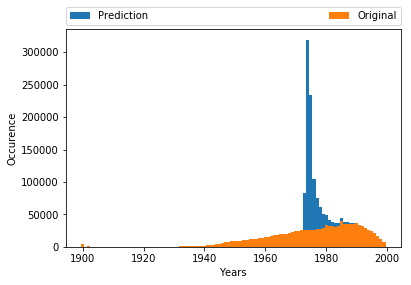

In [39]:
u, indices = np.unique(yob, return_counts=True)
plt.bar(u[1:], indices[1:], label='Prediction', width=1)
u, indices = np.unique(data.yob, return_counts=True)
plt.bar(u[1:], indices[1:], label='Original', width=1)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Years')
plt.ylabel('Occurence')
plt.show()

## Logistic regression to train a model to predict Genders :

In [40]:
df_gender = data.drop(['yob'], axis=1)
print(df_gender.head())

         domain        firstname  zipcode gender
0   @wanadoo.fr  b08253b305fb5ec  94450.0      F
1       @sfr.fr  7ff135854376850  78580.0      M
2      @free.fr  172522ec1028ab7  62640.0    NaN
3  @hotmail.com  d3ca5dde60f88db  94100.0      M
4    @gmail.com  bdaae16837dd576  78100.0    NaN


#### Female/male rate.

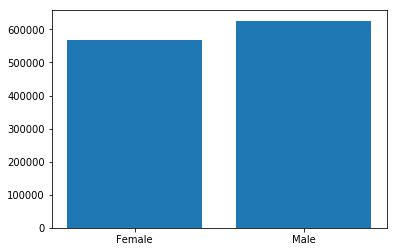

In [41]:
people = np.arange(2)
male = 0
female = 0
for i in data.gender:
    if i == 'M':
        male += 1
    elif i == 'F':
        female += 1
gender_rate = [female, male]
gender_type = ['Female', 'Male']
plt.bar(people, gender_rate)
plt.xticks(people, gender_type)
plt.show()
        

#### Keep the two first number of zipcode

In [42]:
_zip = []
for i in df_gender.zipcode:
    if np.isnan(i) == False and  len(str(int(i))) > 2:
        _zip.append(int(str(i)[:2]))
    else:
        _zip.append(np.nan)
df_gender.zipcode = _zip
print(df_gender.head())

         domain        firstname  zipcode gender
0   @wanadoo.fr  b08253b305fb5ec     94.0      F
1       @sfr.fr  7ff135854376850     78.0      M
2      @free.fr  172522ec1028ab7     62.0    NaN
3  @hotmail.com  d3ca5dde60f88db     94.0      M
4    @gmail.com  bdaae16837dd576     78.0    NaN


In [43]:
features = []
for feature in df_gender.drop(['gender'], axis=1):
    features.append(feature)

labels = []
for label in df_gender:
    labels.append(label)

#### Simplify features by mapping

In [44]:
for feature in features:
    df_gender[feature] = map_features(df_gender[feature])
print(df_gender.head())

   domain  firstname  zipcode gender
0       0          0        0      F
1       1          1        1      M
2       2          2        2    NaN
3       3          3        0      M
4       4          4        1    NaN


#### Get DataFrame to fill with predictions.

In [45]:
gender_to_fil = df_gender.copy()
print(gender_to_fil.head())

   domain  firstname  zipcode gender
0       0          0        0      F
1       1          1        1      M
2       2          2        2    NaN
3       3          3        0      M
4       4          4        1    NaN


#### Map gender label

In [46]:
df_train = delete_nan_rows(df_gender, labels)
df_train['gender'] = df_train['gender'].map({'F': 0, 'M': 1}).astype(int)
gender_to_fil['gender'] = gender_to_fil['gender'].map({'F': 0, 'M': 1})
print(df_train.head())
print(gender_to_fil.head())

   domain  firstname  zipcode  gender
0       0          0        0       0
1       1          1        1       1
2       3          3        0       1
3       0          5        3       1
4       4          6        4       1
   domain  firstname  zipcode  gender
0       0          0        0     0.0
1       1          1        1     1.0
2       2          2        2     NaN
3       3          3        0     1.0
4       4          4        1     NaN


#### Create more revelent data and insert bias

In [47]:
df_train = data_augmentation(df_train, labels, 3)

#### Fit bias to train set and DataFrame.

In [48]:
Bias = np.ones(df_train.shape[0])
df_train.insert(loc=0, column='Bias', value=Bias)
Bias = np.ones(gender_to_fil.shape[0])
gender_to_fil.insert(loc=0, column='Bias', value=Bias)
print(df_train.head())
print(gender_to_fil.head())

   Bias  domain  firstname  zipcode  gender
0   1.0       0          0        0       0
1   1.0       1          1        1       1
2   1.0       3          3        0       1
3   1.0       0          5        3       1
4   1.0       4          6        4       1
   Bias  domain  firstname  zipcode  gender
0   1.0       0          0        0     0.0
1   1.0       1          1        1     1.0
2   1.0       2          2        2     NaN
3   1.0       3          3        0     1.0
4   1.0       4          4        1     NaN


#### Split data to train ans test set and create non scaled copy for accuracy

In [49]:
X_train, Y_train, X_test, Y_test = split_data(df_train)
non_scal_train = X_train.copy()
non_scal_test = X_test.copy()
print(non_scal_train.head())
print(X_train.head())
print(features)

         Bias  domain  firstname  zipcode
665356    1.0       4        683       72
2149914   1.0      64    5177717    68921
2146210   1.0      64     287496     9261
1445409   1.0    2744     405224   636056
1316207   1.0    1331    3241792     1000
         Bias  domain  firstname  zipcode
665356    1.0       4        683       72
2149914   1.0      64    5177717    68921
2146210   1.0      64     287496     9261
1445409   1.0    2744     405224   636056
1316207   1.0    1331    3241792     1000
['domain', 'firstname', 'zipcode']


#### Scaling train and test set

In [50]:
X_train, X_test = gender_features_scaling(X_train, features, X_test)
gender_to_fil, _ = gender_features_scaling(gender_to_fil, features)
print(X_train.head())
print(gender_to_fil.head())
X_train = X_train.values
X_test = X_test.values

         Bias    domain  firstname   zipcode
665356    1.0 -0.213973  -0.136251 -0.409580
2149914   1.0 -0.204062  -0.136226  0.314786
2146210   1.0 -0.204062  -0.136250 -0.312902
1445409   1.0  0.238623  -0.136249  6.281660
1316207   1.0  0.005222  -0.136236 -0.399817
   Bias    domain  firstname   zipcode  gender
0   1.0 -1.124714  -0.515985 -1.407798     0.0
1   1.0 -0.986939  -0.515539 -1.362067     1.0
2   1.0 -0.849165  -0.515093 -1.316336     NaN
3   1.0 -0.711390  -0.514647 -1.407798     1.0
4   1.0 -0.573616  -0.514200 -1.362067     NaN


#### Parameters and theta.

In [51]:
learning_rate = 0.6
nb_epoch = 30

In [52]:
theta_gender = np.zeros(len(features) + 1)
print(theta_gender)

[0. 0. 0. 0.]


#### Training theta.

Cost after epoch 0: 0.692713503548
Cost after epoch 1: 0.692398607003
Cost after epoch 2: 0.692169847454
Cost after epoch 3: 0.692003559572
Cost after epoch 4: 0.6918825985
Cost after epoch 5: 0.691794544174
Cost after epoch 6: 0.691730396431
Cost after epoch 7: 0.69168362972
Cost after epoch 8: 0.691649509448
Cost after epoch 9: 0.691624597828
Cost after epoch 10: 0.691606396702
Cost after epoch 11: 0.69159308927
Cost after epoch 12: 0.691583353211
Cost after epoch 13: 0.691576225352
Cost after epoch 14: 0.691571003596
Cost after epoch 15: 0.691567175783
Cost after epoch 16: 0.691564368037
Cost after epoch 17: 0.691562307243
Cost after epoch 18: 0.691560793758
Cost after epoch 19: 0.69155968155
Cost after epoch 20: 0.691558863732
Cost after epoch 21: 0.69155826202
Cost after epoch 22: 0.691557819043
Cost after epoch 23: 0.691557492731
Cost after epoch 24: 0.691557252215
Cost after epoch 25: 0.691557074832
Cost after epoch 26: 0.691556943933
Cost after epoch 27: 0.691556847279
Cost aft

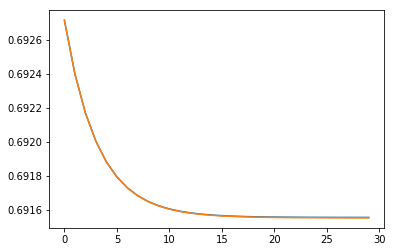

In [53]:
theta_gender = training(X_train, Y_train, X_test, Y_test, theta_gender, learning_rate, nb_epoch)

#### Theta scaling.

In [54]:
theta_gender = gender_theta_scaling(non_scal_train, non_scal_test, theta_gender, features)
print(theta_gender)

[ 0.09852302 -0.21462571 -0.1362514  -0.41033807]


#### Accuracy.

In [55]:
print ('Train accuracy %: {}'.format(Accuracy(theta_gender, X_train, Y_train)))
print ('Test accuracy %: {}'.format(Accuracy(theta_gender, X_test, Y_test)))

Train accuracy %: 42.483965039
Test accuracy %: 42.3581932498


#### Female/male rate after predictions.

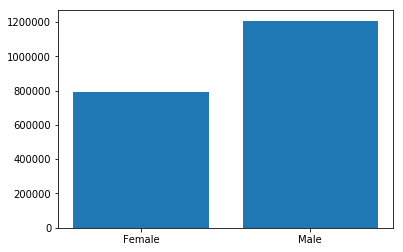

In [62]:
people = np.arange(2)
prediction = sigmoid(np.dot(gender_to_fil.drop(['gender'], axis=1), theta_gender))
pred = []
for i in prediction:
    pred.append(int(round(i)))
male = 0
female = 0
for i in pred:
    if i == 1:
        male += 1
    elif i == 0:
        female += 1
gender_rate = [female, male]
gender_type = ['Female', 'Male']
plt.bar(people, gender_rate)
plt.xticks(people, gender_type)
plt.show()

# Seconde method: RandomForest.

In [57]:
from sklearn.ensemble import RandomForestRegressor

### Predict Year of birth.

#### Data cleaning.

In [58]:
X_yob = data.drop(['gender'], axis=1).copy()
print(X_yob.head())

    yob        domain        firstname  zipcode
0  1985   @wanadoo.fr  b08253b305fb5ec  94450.0
1  1961       @sfr.fr  7ff135854376850  78580.0
2  1977      @free.fr  172522ec1028ab7  62640.0
3    -1  @hotmail.com  d3ca5dde60f88db  94100.0
4    -1    @gmail.com  bdaae16837dd576  78100.0


In [59]:
_zip = []
for i in X_yob.zipcode:
    if np.isnan(i) == False and len(str(int(i))) > 2:
        _zip.append(int(str(i)[:2]))
    else:
        _zip.append(np.nan)
X_yob.zipcode = _zip
print(X_yob.head())

    yob        domain        firstname  zipcode
0  1985   @wanadoo.fr  b08253b305fb5ec     94.0
1  1961       @sfr.fr  7ff135854376850     78.0
2  1977      @free.fr  172522ec1028ab7     62.0
3    -1  @hotmail.com  d3ca5dde60f88db     94.0
4    -1    @gmail.com  bdaae16837dd576     78.0


In [60]:
zip_mean = X_yob['zipcode'].mean()
X_yob.zipcode = X_yob['zipcode'].fillna(zip_mean)

In [61]:
for feature in X_yob.drop(['yob'], axis=1).columns:
    X_yob[feature] = map_features(X_yob[feature])
print(X_yob.head())

    yob  domain  firstname  zipcode
0  1985       0          0        0
1  1961       1          1        1
2  1977       2          2        2
3    -1       3          3        0
4    -1       4          4        1


In [62]:
X = X_yob.copy()
X_yob = cleaning_yob(X_yob, X_yob.columns)
print(X_yob.head())

    yob  domain  firstname  zipcode
0  1985       0          0        0
1  1961       1          1        1
2  1977       2          2        2
3  1975       0          5        3
4  1974       4          6        4


In [63]:
Y_yob = X_yob['yob']
X_yob = X_yob.drop(['yob'], axis=1)

#### Model Training.

In [64]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, min_samples_leaf=4)
model.fit(X_yob, Y_yob)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

           0
1900  0.0002
1901  0.0015
1902  0.0011
1903  0.0009
1904  0.0012
1905  0.0013
1906  0.0010
1907  0.0004
1908  0.0006
1909  0.0009
1910  0.0007
1911  0.0012
1912  0.0008
1913  0.0007
1914  0.0010
1915  0.0024
1916  0.0023
1917  0.0008
1918  0.0010
1919  0.0010
1920  0.0010
1921  0.0009
1922  0.0008
1923  0.0013
1924  0.0016
1925  0.0010
1926  0.0015
1927  0.0014
1928  0.0017
1929  0.0023
...      ...
1968  2.1477
1969  2.2166
1970  2.2628
1971  2.3057
1972  2.3803
1973  2.4968
1974  2.6375
1975  2.8135
1976  2.9227
1977  3.1073
1978  3.2966
1979  3.5285
1980  3.6626
1981  3.9343
1982  4.0348
1983  4.0433
1984  4.1698
1985  4.5760
1986  4.1216
1987  3.8477
1988  3.4318
1989  2.9772
1990  2.3916
1991  1.7694
1992  1.2101
1993  0.6952
1994  0.3747
1995  0.1373
1996  0.0393
1997  0.0041

[98 rows x 1 columns]


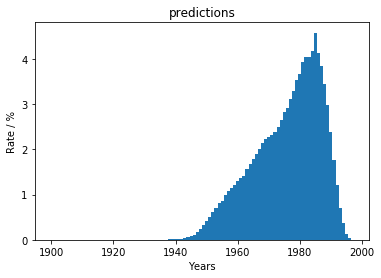

In [79]:
pred = model.oob_prediction_
Yob_prediction = []
for i in pred:
    Yob_prediction.append(int(round(i)))
u, indices = np.unique(Yob_prediction, return_counts=True)
a = float(len(X_yob))

Ocu = []
Yob = []
b = 0
for i in indices:
    Yob.append(u[b])
    Ocu.append(round(((i / a) * 100), 4))
    b += 1
yob_ocu = pd.DataFrame(Ocu, Yob)
print(yob_ocu)
plt.bar(Yob, Ocu, width=1)
plt.xlabel('Years')
plt.ylabel('Rate / %')
plt.title('predictions')
plt.show()

#### Features importance.

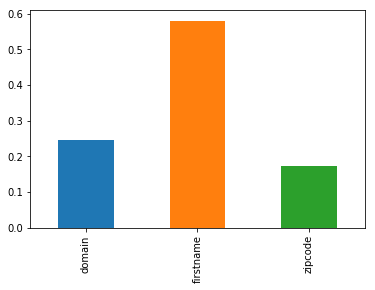

In [65]:
features_impt = pd.Series(model.feature_importances_, index=X_yob.columns)
features_impt.plot(kind='bar')

#### Prediction vs Original.

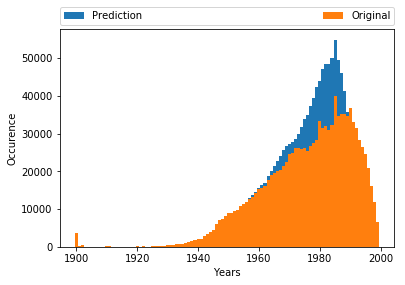

In [66]:
pred = model.oob_prediction_
Yob_prediction = []
for i in pred:
    Yob_prediction.append(int(round(i)))
u, indices = np.unique(Yob_prediction, return_counts=True)
plt.bar(u[1:], indices[1:], label='Prediction', width=1)
u, indices = np.unique(data.yob, return_counts=True)
plt.bar(u[1:], indices[1:], label='Original', width=1)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Years')
plt.ylabel('Occurence')
plt.show()

#### Predict yob missing values, in full data set.

In [67]:
Yob = []
data_set = X.values
prediction = model.predict(X.drop(['yob'], axis=1).values)
for i in range(len(data_set)):
    if data_set[i][0] == -1:
        Yob.append(int(round(prediction[i])))
    else:
        Yob.append(data_set[i][0])

### Predict gender :

#### Data cleaning.

In [20]:
X_gender = data.drop(['yob'], axis=1)
print(X_gender.head())

         domain        firstname  zipcode gender
0   @wanadoo.fr  b08253b305fb5ec  94450.0      F
1       @sfr.fr  7ff135854376850  78580.0      M
2      @free.fr  172522ec1028ab7  62640.0    NaN
3  @hotmail.com  d3ca5dde60f88db  94100.0      M
4    @gmail.com  bdaae16837dd576  78100.0    NaN


In [21]:
_zip = []
for i in X_gender.zipcode:
    if np.isnan(i) == False and len(str(int(i))) > 2:
        _zip.append(int(str(i)[:2]))
    else:
        _zip.append(np.nan)
X_gender.zipcode = _zip
print(X_gender.head())

         domain        firstname  zipcode gender
0   @wanadoo.fr  b08253b305fb5ec     94.0      F
1       @sfr.fr  7ff135854376850     78.0      M
2      @free.fr  172522ec1028ab7     62.0    NaN
3  @hotmail.com  d3ca5dde60f88db     94.0      M
4    @gmail.com  bdaae16837dd576     78.0    NaN


In [22]:
zip_mean = X_gender['zipcode'].mean()
X_gender.zipcode = X_gender['zipcode'].fillna(zip_mean)

In [23]:
for feature in X_gender.drop(['gender'], axis=1).columns:
    X_gender[feature] = map_features(X_gender[feature])
print(X_gender.head())

   domain  firstname  zipcode gender
0       0          0        0      F
1       1          1        1      M
2       2          2        2    NaN
3       3          3        0      M
4       4          4        1    NaN


In [24]:
X = X_gender.copy()
X['gender'] = X['gender'].map({'F': 0, 'M': 1})
X_gender = delete_nan_rows(X_gender, X_gender.columns)
print(X_gender.head())

   domain  firstname  zipcode gender
0       0          0        0      F
1       1          1        1      M
2       3          3        0      M
3       0          5        3      M
4       4          6        4      M


In [25]:
X_gender['gender'] = X_gender['gender'].map({'F': 0, 'M': 1}).astype(int)
print(X_gender.head())

   domain  firstname  zipcode  gender
0       0          0        0       0
1       1          1        1       1
2       3          3        0       1
3       0          5        3       1
4       4          6        4       1


In [26]:
Y_gender = X_gender['gender']
X_gender = X_gender.drop(['gender'], axis=1)

#### Model training.

In [37]:
n_estimators = [30, 50, 70, 100]
acu = []
for trees in n_estimators:
    model = RandomForestRegressor(n_estimators=trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X_gender, Y_gender)
    pred = model.oob_prediction_
    gender_prediction = []
    for i in pred:
        gender_prediction.append(int(round(i)))
    
    correct = 0
    length = len(gender_prediction)
    correct = []
    for i in range(length):
        if gender_prediction[i] == Y_gender.values[i]:
            correct.append(1)
        else:
            correct.append(0)
    accuracy = (np.sum(correct) / float(length))*100
    acu.append(accuracy)
    print('Accuracy for {} trees : {}%'.format(trees, round(accuracy, 4)))

Accuracy for 30 trees : 92.6962%
Accuracy for 50 trees : 92.8199%
Accuracy for 70 trees : 92.8785%
Accuracy for 100 trees : 92.9299%


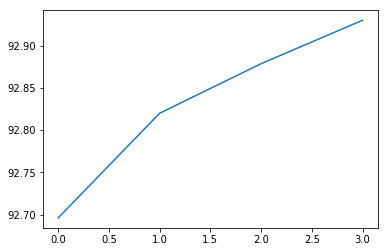

In [38]:
plt.plot(np.arange(len(n_estimators)), acu)
plt.show()

In [39]:
max_features = ['auto', 'sqrt', 'log2', None, 0.2, 0.9]
acu = []
for max_f in max_features:
    model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, max_features=max_f)
    model.fit(X_gender, Y_gender)
    pred = model.oob_prediction_
    gender_prediction = []
    for i in pred:
        gender_prediction.append(int(round(i)))
    
    correct = 0
    length = len(gender_prediction)
    correct = []
    for i in range(length):
        if gender_prediction[i] == Y_gender.values[i]:
            correct.append(1)
        else:
            correct.append(0)
    accuracy = (np.sum(correct) / float(length))*100
    acu.append(accuracy)
    print('Accuracy for {} max features : {}%'.format(max_f, round(accuracy, 4)))

Accuracy for auto max features : 92.9299%
Accuracy for sqrt max features : 84.5498%
Accuracy for log2 max features : 84.5498%
Accuracy for None max features : 92.9299%
Accuracy for 0.2 max features : 84.5498%
Accuracy for 0.9 max features : 89.1039%


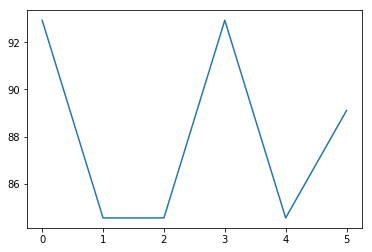

In [40]:
plt.plot(np.arange(len(max_features)), acu)
plt.show()

In [41]:
min_samples_leaf = [1, 2, 3, 4, 5]
acu = []
for leaf in min_samples_leaf:
    model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, max_features=None, min_samples_leaf=leaf)
    model.fit(X_gender, Y_gender)
    pred = model.oob_prediction_
    gender_prediction = []
    for i in pred:
        gender_prediction.append(int(round(i)))
    
    correct = 0
    length = len(gender_prediction)
    correct = []
    for i in range(length):
        if gender_prediction[i] == Y_gender.values[i]:
            correct.append(1)
        else:
            correct.append(0)
    accuracy = (np.sum(correct) / float(length))*100
    acu.append(accuracy)
    print('Accuracy for {} min sample leaf : {}%'.format(leaf, round(accuracy, 4)))

Accuracy for 1 min sample leaf : 92.9299%
Accuracy for 2 min sample leaf : 93.8394%
Accuracy for 3 min sample leaf : 93.9928%
Accuracy for 4 min sample leaf : 94.0104%
Accuracy for 5 min sample leaf : 93.9813%


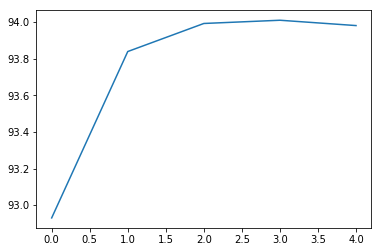

In [42]:
plt.plot(np.arange(len(min_samples_leaf)), acu)
plt.show()

In [43]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, max_features=None, min_samples_leaf=4)
model.fit(X_gender, Y_gender)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

#### Features importance.

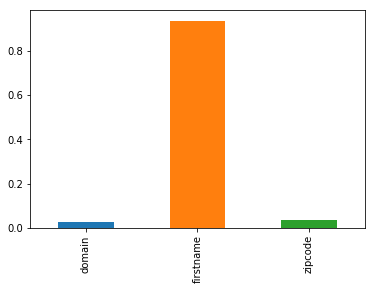

In [44]:
features_impt = pd.Series(model.feature_importances_, index=X_gender.columns)
features_impt.plot(kind='bar')

#### Accuracy.

In [45]:
pred = model.oob_prediction_
gender_prediction = []
for i in pred:
    gender_prediction.append(int(round(i)))
    
correct = 0
length = len(gender_prediction)
correct = []
for i in range(length):
    if gender_prediction[i] == Y_gender.values[i]:
        correct.append(1)
    else:
        correct.append(0)
accuracy = (np.sum(correct) / float(length))*100
print('Predictions accuracy : {}%'.format(round(accuracy, 4)))

Predictions accuracy : 94.0104%


#### Predict gender missing values, in full data set.

In [46]:
Gender = []
data_set = X.values
prediction = model.predict(X.drop(['gender'], axis=1).values)

gender_prediction = []
for i in prediction:
    gender_prediction.append(int(round(i)))

for i in range(len(data_set)):
    if np.isnan(data_set[i][3]):
        Gender.append(gender_prediction[i])
    else:
        Gender.append(data_set[i][3])

#### Fit predictions to full data set.

In [69]:
full_data = data.copy()
full_data.yob = Yob
full_data.gender = Gender
full_data.gender = full_data.gender.map({0: 'F', 1: 'M'})
print(full_data)

          yob             domain        firstname  zipcode gender
0        1985        @wanadoo.fr  b08253b305fb5ec  94450.0      F
1        1961            @sfr.fr  7ff135854376850  78580.0      M
2        1977           @free.fr  172522ec1028ab7  62640.0      M
3        1977       @hotmail.com  d3ca5dde60f88db  94100.0      M
4        1987         @gmail.com  bdaae16837dd576  78100.0      M
5        1975        @wanadoo.fr  57c2877c1d84c4b  92600.0      M
6        1974         @gmail.com  d47de916cacd0b7  65200.0      M
7        1957           @free.fr  7ff135854376850  83250.0      M
8        1977           @live.fr  a5410ee37744c57   5100.0      M
9        1966        @wanadoo.fr  60784186ea5b29f  68300.0      M
10       1961         @gmail.com  aa47f8215c6f30a  67380.0      M
11       1976          @yahoo.fr  66aad1c91c97f58  94250.0      M
12       1980        @wanadoo.fr  d9fee41b5836f7e  33600.0      F
13       1953           @free.fr  d780182f77b1214  24100.0      M
14       1

#### Writing output to 'user_completed.csv'.

In [70]:
full_data.to_csv('user_completed.csv')